© 2022 Soichi Hirokawa. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

# Coupled Flagella Length

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
pn.extension()

In this notebook, we look at the dynamics of two flagella that grow and shrink
due to their shared finite pool of free tubulin and the concentration of depolymerizers at their end. Imagine that we have two flagella of length $L_1$ 
and $L_2$ that share a common pool of tubulin monomers. Further suppose that
the total pool to tubulin is $P$. We will can say that there is an on-rate of
free tubulin $k_\text{on}$ and an off-rate set by the depolymerizers at the
other end (away from the pool) which we showed comes from a linear concentration gradient at steady state due to diffusion $D$ and a flux $R$ of depolymerizers passing through a cross-sectional area $S$. We can then see that
the two time dynamics are of the form

\begin{align}
  \frac{\text{d} L_1}{\text{d} t} &= k_\text{on} \left( P - L_1 - L_2 \right) - k_\text{off} \left[ \frac{R}{D \, S} L_1 + c_0 \right], \tag{1} \\
  \frac{\text{d} L_2}{\text{d} t} &= k_\text{on} \left( P - L_1 - L_2 \right) - k_\text{off} \left[ \frac{R}{D \, S} L_2 + c_0 \right]. \tag{2} \\
\end{align}

Alternatively, to discretize, we will say
\begin{align}
  L_1 \left( t + \Delta t \right) &= L_1 \left( t \right) + k_\text{on} \Delta t \left[ P - L_1 \left( t \right) - L_2 \left( t \right) \right] - k_\text{off} \Delta t \left[ \frac{R}{D \, S} L_1 \left( t \right) + c_0 \right], \tag{3} \\
  L_2 \left( t + \Delta t \right) &= L_2 \left( t \right) + k_\text{on} \Delta t \left[ P - L_1 \left( t \right) - L_2 \left( t \right) \right] - k_\text{off} \Delta t \left[ \frac{R}{D \, S} L_2 \left( t \right) + c_0 \right]. \tag{4} \\
\end{align}

We will extend our experience of numerical integration to a case of coupled
differential equations simply by placing the update rules for both L1 and L2
in the same `for` loop. Here, we make the initial condition that the two 
flagella have no length yet $L_1 \left( 0 \right) = L_2 \left( 0 \right) = 0$.

In [ ]:
# define parameters
dt = 0.01 # sec
k_on = 0.1 # per sec
k_off = 0.1 # per sec
alpha = 3 # R / (D * S)
pool = 10 # nM
c_0 = 1 # nM

# set time steps
n_steps = 1200

# Initialize arrays for L1 and L2
L1 = np.zeros(n_steps)
L2 = np.zeros(n_steps)

# Carry out time dynamics
for t in range(1,n_steps):
  L1[t] = L1[t-1] + k_on * dt * (pool - L1[t-1] - L2[t-1]) - k_off * dt * (alpha * L1[t-1] + c_0)
  L2[t] = L2[t-1] + k_on * dt * (pool - L1[t-1] - L2[t-1]) - k_off * dt * (alpha * L2[t-1] + c_0)

We will for now compare the lengths to the steady state case, which we found to be
\begin{equation}
  L^* = \frac{k_\text{on} P - k_\text{off} c_0}{2 k_\text{on} + \frac{k_\text{off} R}{D \, S}}. \tag{5}
\end{equation}

In [ ]:
L_star = (k_on * pool - k_off * c_0) / (k_off * alpha + 2 * k_on)
print(L_star)

1.8


Text(0, 0.5, 'length')

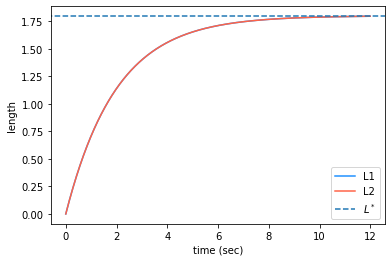

In [ ]:
# Plot both lengths against time
times = np.arange(n_steps) * dt
plt.plot(times, L1, color='dodgerblue', label='L1')
plt.plot(times, L2, color='tomato', label='L2')

plt.axhline(L_star, -1, 11, linestyle='--', label='$L^*$')

plt.legend(loc=4)

plt.xlabel('time (sec)')
plt.ylabel('length')

Here we see that both flagella grow at the same rate. This is consistent with
our expectations since they both have symmetric differential equations and the
same initial conditions.

As an option, we can create a crude animation that shows both flagella growing
using the slider from `panel`.

Column
    [0] FloatSlider(end=1199, name='time slider', step=1)
    [1] ParamFunction(function)
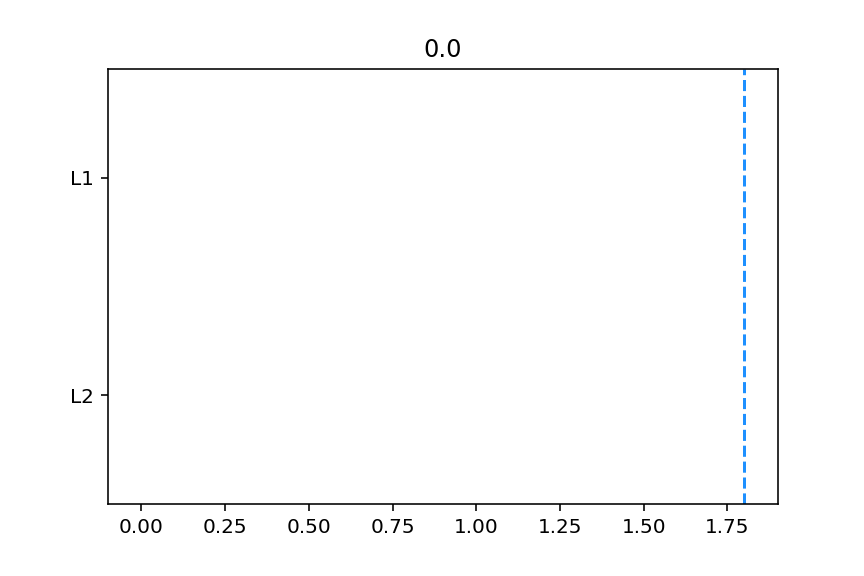

In [ ]:
times = np.arange(n_steps) * dt

# Interactive plot of the lengths over time

time_slider = pn.widgets.FloatSlider(
    name='time slider',
    start=0,
    end=n_steps-1,
    step=1,
    value=0
)
@pn.depends(time_slider.param.value) # make a new plot when the parameters in time_slider change
def slider(frame):
    # Initialize plot
    fig, ax = plt.subplots(1,1) # Making one figure in our interactive plot
    # Generate plot of distribution
    ax.barh([0.25, 0.75], [L2[frame], L1[frame]], [0.25, 0.25])

    # Draw a vertical line for the steady-state length
    ax.axvline(L_star, 0, 1, linestyle='--', color='dodgerblue')
    ax.set_yticks([0.25, 0.75])
    ax.set_yticklabels(['L2', 'L1'])
    ax.set_title(np.round(times[frame], 1))
    # Set height for all plots
    ax.set_xlim([-0.1, L_star + 0.1])
    ax.set_ylim([0, 1])
    plt.close(fig)
    return fig

pn.Column(time_slider,
          slider)

Now let's imagine that after both flagella reached a steady-state length, we
cut off one of the flagella so that it returns back to having no length
$L_2 \left( 0 \right) = 0$ while the other is still at the original steady
state length $L_1 \left( 0 \right) = L^*$. I say original steady state because
now that we have taken the tubulin that were a part of $L_2$, we have reduced
our pool of monomers to $P_\text{cut} = P - L^*$. This then has an effect on
the dynamics. Let's see that now.

In [ ]:
# create a new pool but initial condition is L_star for one and 0 for the other
dt = 0.01
k_on = 0.1
k_off = 0.1
alpha = 3
pool = 10
c_0 = 1

n_steps = 1200

# our pool of monomers has changed
pool_cut = pool - L_star

# compute new L^*
L_star2 = (k_on * pool_cut - k_off * c_0) / (k_off * alpha + 2 * k_on)


L1 = np.zeros(n_steps)
# set new initial condition for L_1
L1[0] = L_star

L2 = np.zeros(n_steps)

# Carry out time dynamics
for t in range(1,n_steps):
  L1[t] = L1[t-1] + k_on * dt * (pool_cut - L1[t-1] - L2[t-1]) - k_off * dt * (alpha * L1[t-1] + c_0)
  L2[t] = L2[t-1] + k_on * dt * (pool_cut - L1[t-1] - L2[t-1]) - k_off * dt * (alpha * L2[t-1] + c_0)

Fortunately, we have analytical solutions for Eq. 1 and 2. By making the change of variables $\bar{L} \left( t \right) \equiv L_1 \left( t \right) + L_2 \left( t \right)$ and $\underline{L} \left( t \right) \equiv L_1 \left( t \right) - L_2 \left( t \right)$, we can obtain analytical solutions
to the coupled differential equations. The solutions, though messy, become

\begin{align}
  L_1 \left( t \right) &= L^* \left\{ 1 - \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right]  \right\} + \frac{L_{1,0} + L_{2,0}}{2} \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right] + \frac{L_{1,0} - L_{2,0}}{2} \exp \left( - \frac{k_\text{off} \, R}{D \, S} t \right), \tag{6} \\
  L_2 \left( t \right) &= L^* \left\{ 1 - \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right]  \right\} + \frac{L_{1,0} + L_{2,0}}{2} \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right] + \frac{L_{2,0} - L_{1,0}}{2} \exp \left( - \frac{k_\text{off} \, R}{D \, S} t \right), \tag{7}
\end{align}
where we define
\begin{equation}
  L^* \equiv \frac{k_\text{on} P - k_\text{off} c_0}{2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S}}. \tag{8}
\end{equation}

If we imagine that the pool has shrunk from $P$ to $P - L^*$ from cutting one
of the cilia once we had reached the original steady-state, our equations
for $L_1$ and $L_2$ are specified as
\begin{align}
  L_1 \left( t \right) &= L_\text{cut}^* \left\{ 1 - \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right]  \right\} + \frac{L^*}{2} \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right] + \frac{L^*}{2} \exp \left( - \frac{k_\text{off} \, R}{D \, S} t \right), \tag{9} \\
  L_2 \left( t \right) &= L_\text{cut}^* \left\{ 1 - \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right]  \right\} + \frac{L^*}{2} \exp \left[ - \left( 2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S} \right) t \right] - \frac{L^*}{2} \exp \left( - \frac{k_\text{off} \, R}{D \, S} t \right), \tag{10}
\end{align}
where
\begin{equation}
  L_\text{cut}^* \equiv \frac{k_\text{on} \left( P - L^* \right) - k_\text{off} c_0}{2 k_\text{on} + \frac{k_\text{off} \, R}{D \, S}}. \tag{11}
\end{equation}

Let's apply this to the plot for $L_1$ and $L_2$ to validate the numerical integration.

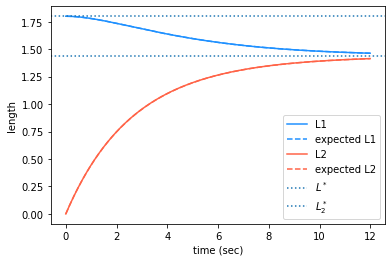

<Figure size 2304x1152 with 0 Axes>

In [ ]:
times = np.arange(n_steps) * dt

common_term = L_star2 * (1 - np.exp(- (2 * k_on + k_off * alpha) * times))

L1_pred = common_term + L_star / 2 * (np.exp(- (2 * k_on + k_off * alpha) * times) + np.exp(- k_off * alpha * times))
L2_pred = common_term + L_star / 2 * (np.exp(- (2 * k_on + k_off * alpha) * times) - np.exp(- k_off * alpha * times))

plt.plot(times, L1, color='dodgerblue', label='L1')
plt.plot(times, L1_pred, '--', color='dodgerblue', label='expected L1')

plt.plot(times, L2, color='tomato', label='L2')
plt.plot(times, L2_pred, '--', color='tomato', label='expected L2')

plt.axhline(L_star, -1, 11, linestyle=':', label='$L^*$')
plt.axhline(L_star2, -1, 11, linestyle=':', label='$L_2^*$')

plt.legend(loc=4)

plt.xlabel('time (sec)')
plt.ylabel('length')
plt.figure(figsize=(32,16));

We see the agreement between the analytical results and the numerical 
integration. For fun, we can visualize on flagellum shrinking in length while
the other begins to grow using a slider.

Column
    [0] FloatSlider(end=1199, name='time slider', step=1)
    [1] ParamFunction(function)
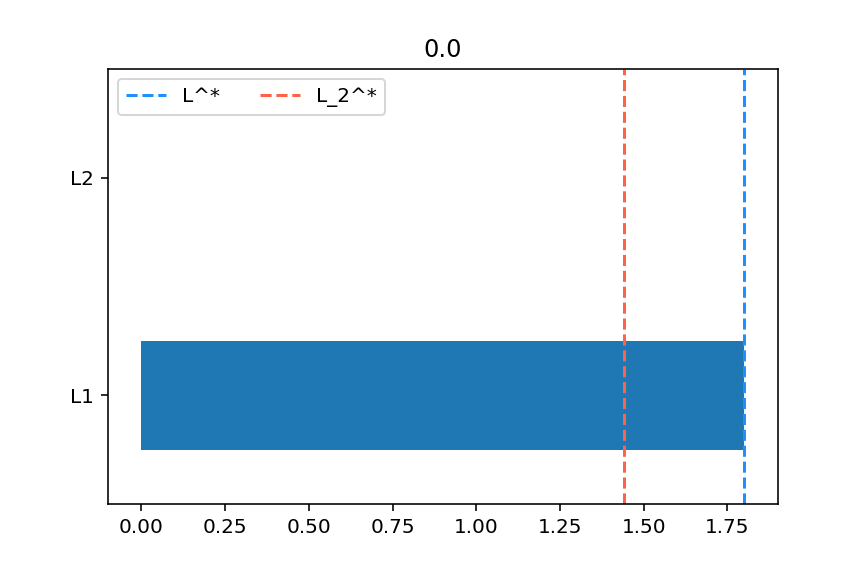

In [ ]:
# Interactive plot of the lengths over time

time_slider = pn.widgets.FloatSlider(
    name='time slider',
    start=0,
    end=n_steps-1,
    step=1,
    value=0
)
@pn.depends(time_slider.param.value) # make a new plot when the parameters in time_sliderr change
def slider(frame):
    # Initialize plot
    fig, ax = plt.subplots(1,1) # Making one figure in our interactive plot
    # Generate plot of distribution
    ax.barh([0.25, 0.75], [L1[frame], L2[frame]], [0.25, 0.25])
    
    # Plot expected lines
    ax.axvline(L_star, 0, 1, linestyle='--', label='L^*', color='dodgerblue')
    ax.axvline(L_star2, 0, 1, linestyle='--', label='L_2^*', color='tomato')

    ax.set_yticks([0.25, 0.75])
    ax.set_yticklabels(['L1', 'L2'])
    ax.set_title(np.round(times[frame], 1))
    # Set height for all plots
    ax.set_xlim([-0.1, L_star + 0.1])
    ax.set_ylim([0, 1])

    ax.legend(loc=2, ncol=2)

    plt.close(fig)
    return fig

pn.Column(time_slider,
          slider)